# Working with Market Depth and Trades

## Display 3-depth

In [1]:
from numba import njit

@njit
def print_3depth(hbt):
    while hbt.elapse(60 * 1e6):
        # a key of bid_depth or ask_depth is price in tick format.
        # (integer) price_tick = price / tick_size
        print('current_timestamp:', hbt.current_timestamp)
        i = 0
        for tick_price in range(hbt.best_ask_tick, hbt.high_ask_tick + 1):
            if tick_price in hbt.ask_depth:
                print(
                    'ask: ',
                    hbt.ask_depth[tick_price],
                    '@',
                    round(tick_price * hbt.tick_size, 3)
                )
                i += 1
                if i == 3:
                    break
        i = 0
        for tick_price in range(hbt.best_bid_tick, hbt.low_bid_tick - 1, -1):
            if tick_price in hbt.bid_depth:
                print(
                    'bid: ',
                    hbt.bid_depth[tick_price],
                    '@',
                    round(tick_price * hbt.tick_size, 3)
                )
                i += 1
                if i == 3:
                    break
    return True

In [2]:
import numpy as np

btcusdt_20230405 = np.load('btcusdt_20230405.npz')['data']
btcusdt_20230404_eod = np.load('btcusdt_20230404_eod.npz')['data']

In [3]:
from hftbacktest import HftBacktest, FeedLatency, Linear

hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

print_3depth(hbt)

current_timestamp: 1680652860032116
ask:  9.228 @ 28150.8
ask:  0.387 @ 28150.9
ask:  3.996 @ 28151.0
bid:  3.135 @ 28150.7
bid:  0.002 @ 28150.6
bid:  0.813 @ 28150.5
current_timestamp: 1680652920032116
ask:  1.224 @ 28144.2
ask:  0.223 @ 28144.3
ask:  0.001 @ 28144.5
bid:  10.529 @ 28144.1
bid:  0.168 @ 28144.0
bid:  0.29 @ 28143.9
current_timestamp: 1680652980032116
ask:  3.397 @ 28150.0
ask:  1.282 @ 28150.1
ask:  0.003 @ 28150.4
bid:  7.951 @ 28149.9
bid:  0.02 @ 28149.8
bid:  0.02 @ 28149.7
current_timestamp: 1680653040032116
ask:  3.905 @ 28145.8
ask:  1.695 @ 28145.9
ask:  0.003 @ 28146.0
bid:  5.793 @ 28145.7
bid:  0.059 @ 28145.6
bid:  0.044 @ 28145.5
current_timestamp: 1680653100032116
ask:  6.8 @ 28140.6
ask:  0.001 @ 28140.7
ask:  0.004 @ 28141.1
bid:  2.416 @ 28140.5
bid:  0.004 @ 28140.4
bid:  0.012 @ 28140.3
current_timestamp: 1680653160032116
ask:  3.666 @ 28143.9
ask:  1.422 @ 28144.0
ask:  1.455 @ 28144.1
bid:  3.189 @ 28143.8
bid:  5.136 @ 28143.7
bid:  0.012 @ 2814

True

## Order Book Imbalance

In [4]:
@njit
def orderbookimbalance(hbt, out):
    while hbt.elapse(10 * 1e6):
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0
        
        sum_ask_qty_50bp = 0.0
        sum_ask_qty = 0.0
        for tick_price in range(hbt.best_ask_tick, hbt.high_ask_tick + 1):
            if tick_price in hbt.ask_depth:
                ask_price = tick_price * hbt.tick_size
                depth_from_mid = (ask_price - mid_price) / mid_price
                if depth_from_mid > 0.01:
                    break
                sum_ask_qty += hbt.ask_depth[tick_price]
                
                if depth_from_mid <= 0.005:
                    sum_ask_qty_50bp = sum_ask_qty
                
                
        sum_bid_qty_50bp = 0.0
        sum_bid_qty = 0.0
        for tick_price in range(hbt.best_bid_tick, hbt.low_bid_tick - 1, -1):
            if tick_price in hbt.bid_depth:
                bid_price = tick_price * hbt.tick_size
                depth_from_mid = (mid_price - bid_price) / mid_price
                if depth_from_mid > 0.01:
                    break
                sum_bid_qty += hbt.bid_depth[tick_price]
                
                if depth_from_mid <= 0.005:
                    sum_bid_qty_50bp = sum_bid_qty
                
        imbalance_50bp = sum_bid_qty_50bp - sum_ask_qty_50bp
        imbalance_1pct = sum_bid_qty - sum_ask_qty
        imbalance_tob = hbt.bid_depth[hbt.best_bid_tick] - hbt.ask_depth[hbt.best_ask_tick]
        
        out.append((hbt.current_timestamp, imbalance_tob, imbalance_50bp, imbalance_1pct))        
    return True

In [5]:
from numba.typed import List
from numba.types import Tuple, float64

hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

tup_ty = Tuple((float64, float64, float64, float64))
out = List.empty_list(tup_ty, allocated=100_000)

orderbookimbalance(hbt, out)

True

In [6]:
import polars as pl

df = pl.DataFrame(out).transpose()
df.columns = ['Local Timestamp', 'TOB Imbalance', '0.5% Imbalance', '1% Imbalance']
df = df.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='us')
)

df

Local Timestamp,TOB Imbalance,0.5% Imbalance,1% Imbalance
datetime[μs],f64,f64,f64
2023-04-05 00:00:10.032116,10.62,79.522,-521.026
2023-04-05 00:00:20.032116,-4.868,-152.592,-684.247
2023-04-05 00:00:30.032116,0.59,-161.95,-701.843
2023-04-05 00:00:40.032116,3.962,-142.51,-669.033
2023-04-05 00:00:50.032116,4.912,-114.827,-653.331
2023-04-05 00:01:00.032116,-6.093,273.067,-755.551
2023-04-05 00:01:10.032116,10.201,-36.007,-701.998
2023-04-05 00:01:20.032116,3.009,121.205,-735.241
2023-04-05 00:01:30.032116,8.383,381.521,-704.022


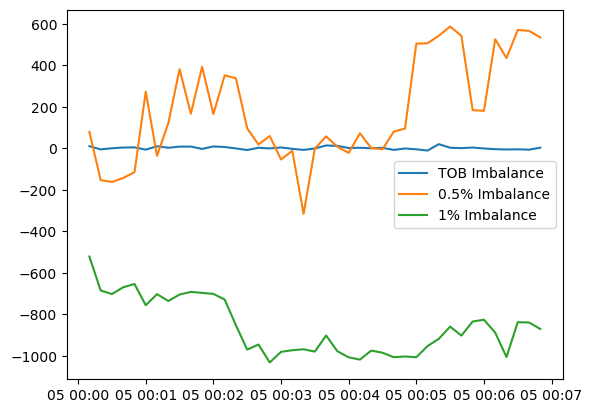

In [7]:
import matplotlib.pyplot as plt

plt.plot(df['Local Timestamp'], df['TOB Imbalance'])
plt.plot(df['Local Timestamp'], df['0.5% Imbalance'])
plt.plot(df['Local Timestamp'], df['1% Imbalance'])

plt.legend(['TOB Imbalance', '0.5% Imbalance', '1% Imbalance'])

## Display last trades between the step

In [31]:
from hftbacktest import COL_EXCH_TIMESTAMP, COL_SIDE, COL_PRICE, COL_QTY

@njit
def print_trades(hbt):
    while hbt.elapse(60 * 1e6):
        print('-------------------------------------------------------------------------------')
        print('current_timestamp:', hbt.current_timestamp)
        
        num = 0
        for trade in hbt.last_trades:
            if num > 10:
                print('...')
                break
            print(
                'exch_timestamp:',
                trade[COL_EXCH_TIMESTAMP],
                'buy' if trade[COL_SIDE] == 1 else 'sell',
                trade[COL_QTY],
                '@',
                trade[COL_PRICE]
            )
            num += 1
        
        hbt.clear_last_trades()
    return True

In [32]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod,
    trade_list_size=10_000
)

print_trades(hbt)

-------------------------------------------------------------------------------
current_timestamp: 1680652860032116
exch_timestamp: 1680652804962000.0 sell 0.001 @ 28155.1
exch_timestamp: 1680652804964000.0 buy 0.012 @ 28155.2
exch_timestamp: 1680652804966000.0 buy 0.002 @ 28155.2
exch_timestamp: 1680652804968000.0 buy 0.003 @ 28155.2
exch_timestamp: 1680652804981000.0 sell 0.019 @ 28155.1
exch_timestamp: 1680652804981000.0 sell 0.004 @ 28155.1
exch_timestamp: 1680652804981000.0 sell 0.001 @ 28155.1
exch_timestamp: 1680652804981000.0 sell 0.02 @ 28155.1
exch_timestamp: 1680652804981000.0 sell 0.013 @ 28155.1
exch_timestamp: 1680652804981000.0 sell 0.002 @ 28155.1
exch_timestamp: 1680652804981000.0 sell 0.001 @ 28155.0
...
-------------------------------------------------------------------------------
current_timestamp: 1680652920032116
exch_timestamp: 1680652860008000.0 buy 1.887 @ 28150.8
exch_timestamp: 1680652860008000.0 buy 0.139 @ 28150.8
exch_timestamp: 1680652860009000.0 buy 0.0

True

## Rolling Volume-Weighted Average Price

In [10]:
@njit
def rolling_vwap(hbt, out):
    buy_amount_bin = np.zeros(100_000, np.float64)
    buy_qty_bin = np.zeros(100_000, np.float64)
    sell_amount_bin = np.zeros(100_000, np.float64)
    sell_qty_bin = np.zeros(100_000, np.float64)
    
    idx = 0
    last_trade_price = np.nan
    
    while hbt.elapse(10 * 1e6):
        for trade in hbt.last_trades:
            if trade[COL_SIDE] == 1:
                buy_amount_bin[idx] += trade[COL_PRICE] * trade[COL_QTY]
                buy_qty_bin[idx] += trade[COL_QTY]
            else:
                sell_amount_bin[idx] += trade[COL_PRICE] * trade[COL_QTY]
                sell_qty_bin[idx] += trade[COL_QTY]
        hbt.clear_last_trades()
        idx += 1

        if idx >= 1:
            vwap10sec = np.divide(
                buy_amount_bin[idx - 1] + sell_amount_bin[idx - 1], 
                buy_qty_bin[idx - 1] + sell_qty_bin[idx - 1]
            )
        else:
            vwap10sec = np.nan
        
        if idx >= 6:
            vwap1m = np.divide(
                np.sum(buy_amount_bin[idx - 6:idx]) + np.sum(sell_amount_bin[idx - 6:idx]), 
                np.sum(buy_qty_bin[idx - 6:idx]) + np.sum(sell_qty_bin[idx - 6:idx])
            )
            buy_vwap1m = np.divide(np.sum(buy_amount_bin[idx - 6:idx]), np.sum(buy_qty_bin[idx - 6:idx]))
            sell_vwap1m = np.divide(np.sum(sell_amount_bin[idx - 6:idx]), np.sum(sell_qty_bin[idx - 6:idx]))
        else:
            vwap1m = np.nan
            buy_vwap1m = np.nan
            sell_vwap1m = np.nan
        
        out.append((hbt.current_timestamp, vwap10sec, vwap1m, buy_vwap1m, sell_vwap1m))
    return True

In [11]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod,
    trade_list_size=1_000_000
)

tup_ty = Tuple((float64, float64, float64, float64, float64))
out = List.empty_list(tup_ty, allocated=100_000)

rolling_vwap(hbt, out)

True

In [12]:
df = pl.DataFrame(out).transpose()
df.columns = ['Local Timestamp', '10-sec VWAP', '1-min VWAP', '1-min Buy VWAP', '1-min Sell VWAP']
df = df.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='us')
)

df

Local Timestamp,10-sec VWAP,1-min VWAP,1-min Buy VWAP,1-min Sell VWAP
datetime[μs],f64,f64,f64,f64
2023-04-05 00:00:10.032116,28152.252939,NaN,NaN,NaN
2023-04-05 00:00:20.032116,28155.780263,NaN,NaN,NaN
2023-04-05 00:00:30.032116,28158.015906,NaN,NaN,NaN
2023-04-05 00:00:40.032116,28155.813019,NaN,NaN,NaN
2023-04-05 00:00:50.032116,28156.783983,NaN,NaN,NaN
2023-04-05 00:01:00.032116,28154.537949,28155.548141,28155.915523,28155.223338
2023-04-05 00:01:10.032116,28148.396356,28153.368132,28154.890947,28152.319296
2023-04-05 00:01:20.032116,28146.825218,28152.039289,28153.901905,28150.83132
2023-04-05 00:01:30.032116,28144.455386,28150.627706,28151.934098,28149.81655


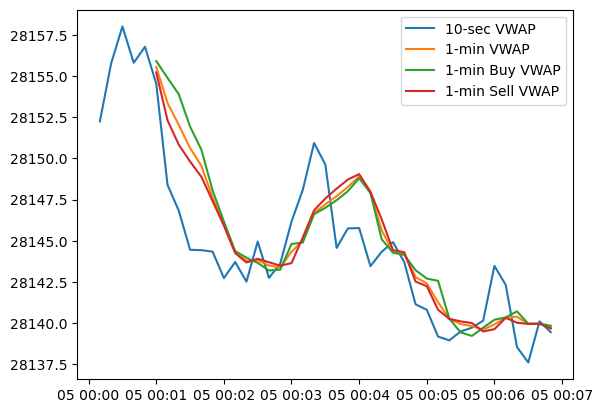

In [13]:
plt.plot(df['Local Timestamp'], df['10-sec VWAP'])
plt.plot(df['Local Timestamp'], df['1-min VWAP'])
plt.plot(df['Local Timestamp'], df['1-min Buy VWAP'])
plt.plot(df['Local Timestamp'], df['1-min Sell VWAP'])

plt.legend(['10-sec VWAP', '1-min VWAP', '1-min Buy VWAP', '1-min Sell VWAP'])